# AlexNet

Outline
- Introduction
- Model Definition
- Weight Initialisations
- Learning Rate Finder
- Training
- Results

In [26]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary
import shutil
import math
from IPython import display

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Introduction

In this jupyter notebook we will be implementing a flavour of [AlexNet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf), which was the winner of [ImageNet Challenge](https://image-net.org/challenges/LSVRC/) in 2012. Before moving forward, we should look at the dataset we will using for this excercise. 

### CIFAR10
This dataset consists of 60K 32x32 RGB images, with 6K images per class. These classes are: airplane, bird, cat, dog, frog, horse, ship, truck.

In [27]:
# Repeatability of results
torch.manual_seed(1)

# We want to train our model on a hardware accelerator like the GPU, if it is available.
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device} device")

# The number of images in a mini-batch
batch_size = 64

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 2,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

Using cuda device


In [28]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=True,
    transform=transform)

test_set = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set, **train_kwargs)

test_loader = torch.utils.data.DataLoader(validation_set, **test_kwargs)

# print the dataset
print(f'Size of training set = {len(training_set)}')
print(f'Size of test set = {len(test_set)}')
# print for dataset loader
print(f'Size of training set = {len(training_loader)}') # ceil(len(training_set) / batch_size)
print(f'Size of test set = {len(test_loader)}')

Files already downloaded and verified
Files already downloaded and verified
Size of training set = 50000
Size of test set = 10000
Size of training set = 782
Size of test set = 157


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


One Batch Dimension = torch.Size([64, 3, 32, 32]), Labels Dimension = torch.Size([64])


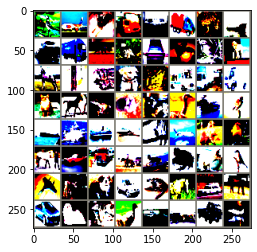

In [30]:
# Helper function for inline image display
def matplotlib_imshow(img):
    idx = [0, 1, 2]
    mean = torch.Tensor([0.49139968, 0.48215841, 0.44653091])
    std = torch.Tensor([0.24703223, 0.24348513, 0.26158784])
    for i in idx:
        #img[i] = img[i].mean(dim=0)
        img[i] = torch.div(img[i], std[i]) 
        img[i] = torch.add(img[i], mean[i])    # unnormalize the image for visualisation
    img = img.permute((1,2,0))
    npimg = img.numpy()
    plt.imshow(npimg)
    
# Extract a batch of images
dataiter = iter(training_loader)
images, labels = dataiter.next()

print(f'One Batch Dimension = {images.shape}, Labels Dimension = {labels.shape}')

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)

# Default log_dir argument is "runs" - but it's good to be specific
shutil.rmtree('runs/cifar10_experiment_1')
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/cifar10_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image(f'{batch_size} CIFAR10 Images', img_grid)
writer.flush()